# Solar Radiation Prediction
### Task from NASA Hackathon

by: Isart Gaspà

El Objetivo de la práctica es predecir la Radiación solar con los datos obtenidos de la Nasa en Hawaii. La tabla de datos contiene datos cada 5 minutos para los meses de setiembre a diciembre de 2016.

Caragar las librerias

In [310]:
import numpy as np
import pandas as pd
import os
import pickle
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sn
from scipy import stats
from datetime import datetime
from pytz import timezone
import pytz

Cargar el dataset

In [311]:
dataset = pd.read_csv("SolarPrediction.csv")
dataset.head()

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet
0,1475229326,9/29/2016 12:00:00 AM,23:55:26,1.21,48,30.46,59,177.39,5.62,06:13:00,18:13:00
1,1475229023,9/29/2016 12:00:00 AM,23:50:23,1.21,48,30.46,58,176.78,3.37,06:13:00,18:13:00
2,1475228726,9/29/2016 12:00:00 AM,23:45:26,1.23,48,30.46,57,158.75,3.37,06:13:00,18:13:00
3,1475228421,9/29/2016 12:00:00 AM,23:40:21,1.21,48,30.46,60,137.71,3.37,06:13:00,18:13:00
4,1475228124,9/29/2016 12:00:00 AM,23:35:24,1.17,48,30.46,62,104.95,5.62,06:13:00,18:13:00


In [312]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32686 entries, 0 to 32685
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   UNIXTime                32686 non-null  int64  
 1   Data                    32686 non-null  object 
 2   Time                    32686 non-null  object 
 3   Radiation               32686 non-null  float64
 4   Temperature             32686 non-null  int64  
 5   Pressure                32686 non-null  float64
 6   Humidity                32686 non-null  int64  
 7   WindDirection(Degrees)  32686 non-null  float64
 8   Speed                   32686 non-null  float64
 9   TimeSunRise             32686 non-null  object 
 10  TimeSunSet              32686 non-null  object 
dtypes: float64(4), int64(3), object(4)
memory usage: 2.7+ MB


Hay un total de 32.686 filas en nuestro Dataset

Observamos que no tenemos valor nulos en ninguna de las 10 columnas

In [313]:
dataset[dataset.duplicated(keep="first")]

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet


No existen duplicados tampoco

Tal como se observa en el dataset, las features tienen unas mediciones cada 5 minutos. Lo que nos implica una serie de transformaciones en las features data y time para poder trabajar con ellas.

In [314]:
#Localización
hawaii= timezone('Pacific/Honolulu')
dataset.index =  pd.to_datetime(dataset['UNIXTime'], unit='s')
dataset.index = dataset.index.tz_localize(pytz.utc).tz_convert(hawaii)

#Mes, Dia del Año
dataset["Mes"]=dataset.index.strftime("%m").astype(int)
dataset["dia_del_any"]=dataset.index.strftime("%j").astype(int)

#Hora, minutos y segundos del dia
dataset["Hora"]=dataset.index.hour
dataset["Minutosdeldia"]=dataset.index.hour*60+dataset.index.minute
dataset["Segundosdeldia"]=dataset.index.hour*60+dataset.index.minute*60+dataset.index.second

#transformamos las variables objeto en datos de Datetime y calculamos el timpo de sol durante el dia en una nueva variable
dataset["TimeSunRise"]=pd.to_datetime(dataset["TimeSunRise"])
dataset["TimeSunSet"]=pd.to_datetime(dataset["TimeSunSet"])
dataset["Segundosdesol"]=dataset["TimeSunSet"]-dataset["TimeSunRise"]
dataset["Segundosdesol"]=dataset["Segundosdesol"].dt.total_seconds()

#limieza de fetarues ya usadas
dataset.drop(["Data", "Time","TimeSunRise", "TimeSunSet"], inplace=True, axis=1)
dataset

,UNIXTime,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,Mes,dia_del_any,Hora,Minutosdeldia,Segundosdeldia,Segundosdesol
UNIXTime,,,,,,,,,,,,,
2016-09-29 23:55:26-10:00,1475229326,1.21,48,30.46,59,177.39,5.62,9,273,23,1435,4706,43200.0
2016-09-29 23:50:23-10:00,1475229023,1.21,48,30.46,58,176.78,3.37,9,273,23,1430,4403,43200.0
2016-09-29 23:45:26-10:00,1475228726,1.23,48,30.46,57,158.75,3.37,9,273,23,1425,4106,43200.0
2016-09-29 23:40:21-10:00,1475228421,1.21,48,30.46,60,137.71,3.37,9,273,23,1420,3801,43200.0
2016-09-29 23:35:24-10:00,1475228124,1.17,48,30.46,62,104.95,5.62,9,273,23,1415,3504,43200.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-01 00:20:04-10:00,1480587604,1.22,44,30.43,102,145.42,6.75,12,336,0,20,1204,39660.0
2016-12-01 00:15:01-10:00,1480587301,1.17,44,30.42,102,117.78,6.75,12,336,0,15,901,39660.0
2016-12-01 00:10:01-10:00,1480587001,1.20,44,30.42,102,145.19,9.00,12,336,0,10,601,39660.0


In [315]:
#agrupamos por días para obtener el promedio de radiación

In [316]:
mediadelahora=dataset.groupby("Hora").mean()
type(mediadelahora)
mediadelahora.head()

,UNIXTime,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,Mes,dia_del_any,Minutosdeldia,Segundosdeldia,Segundosdesol
Hora,,,,,,,,,,,,
0,1.478336e+09,1.317216,46.878210,30.429246,75.277548,162.447067,6.144383,10.633803,309.937862,28.641259,1736.207125,41227.009114
1,1.477931e+09,1.381874,46.709117,30.419855,75.758321,163.667323,6.365810,10.500724,305.210564,87.608538,1734.121563,41484.659913
2,1.477931e+09,1.385730,46.305636,30.408569,74.004335,163.823873,6.269538,10.497110,305.159682,147.523121,1788.641618,41487.355491
3,1.477937e+09,1.365340,46.125723,30.401272,73.711705,163.899364,6.473634,10.497832,305.187861,207.540462,1850.117052,41485.534682
4,1.477922e+09,1.363999,45.917147,30.401448,73.359510,167.301405,6.701275,10.492075,304.971902,267.538184,1909.690922,41497.305476


In [504]:
r=list(mediadelahora["Radiation"])
index=np.arange(1,25,1)

<BarContainer object of 24 artists>

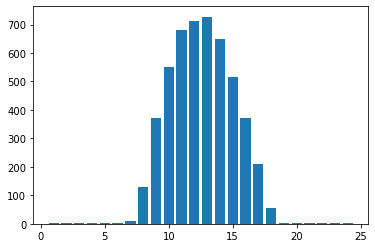

In [319]:
plt.bar(index, r)

La máxima radiación corresponde con el mediodía tal como era de suponer

In [502]:
mediadeldia=dataset.groupby("dia_del_any").mean()
rdia=list(mediadeldia["Radiation"])
indexdias=np.arange(1,119,1)

<BarContainer object of 118 artists>

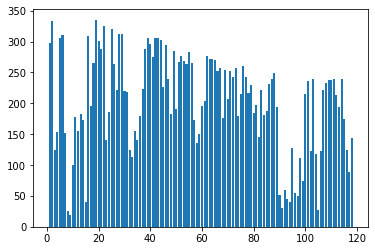

In [322]:
plt.bar(indexdias, rdia)

array([[<AxesSubplot:title={'center':'UNIXTime'}>,
        <AxesSubplot:title={'center':'Radiation'}>,
        <AxesSubplot:title={'center':'Temperature'}>,
        <AxesSubplot:title={'center':'Pressure'}>],
       [<AxesSubplot:title={'center':'Humidity'}>,
        <AxesSubplot:title={'center':'WindDirection(Degrees)'}>,
        <AxesSubplot:title={'center':'Speed'}>,
        <AxesSubplot:title={'center':'Mes'}>],
       [<AxesSubplot:title={'center':'dia_del_any'}>,
        <AxesSubplot:title={'center':'Hora'}>,
        <AxesSubplot:title={'center':'Minutosdeldia'}>,
        <AxesSubplot:title={'center':'Segundosdeldia'}>],
       [<AxesSubplot:title={'center':'Segundosdesol'}>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

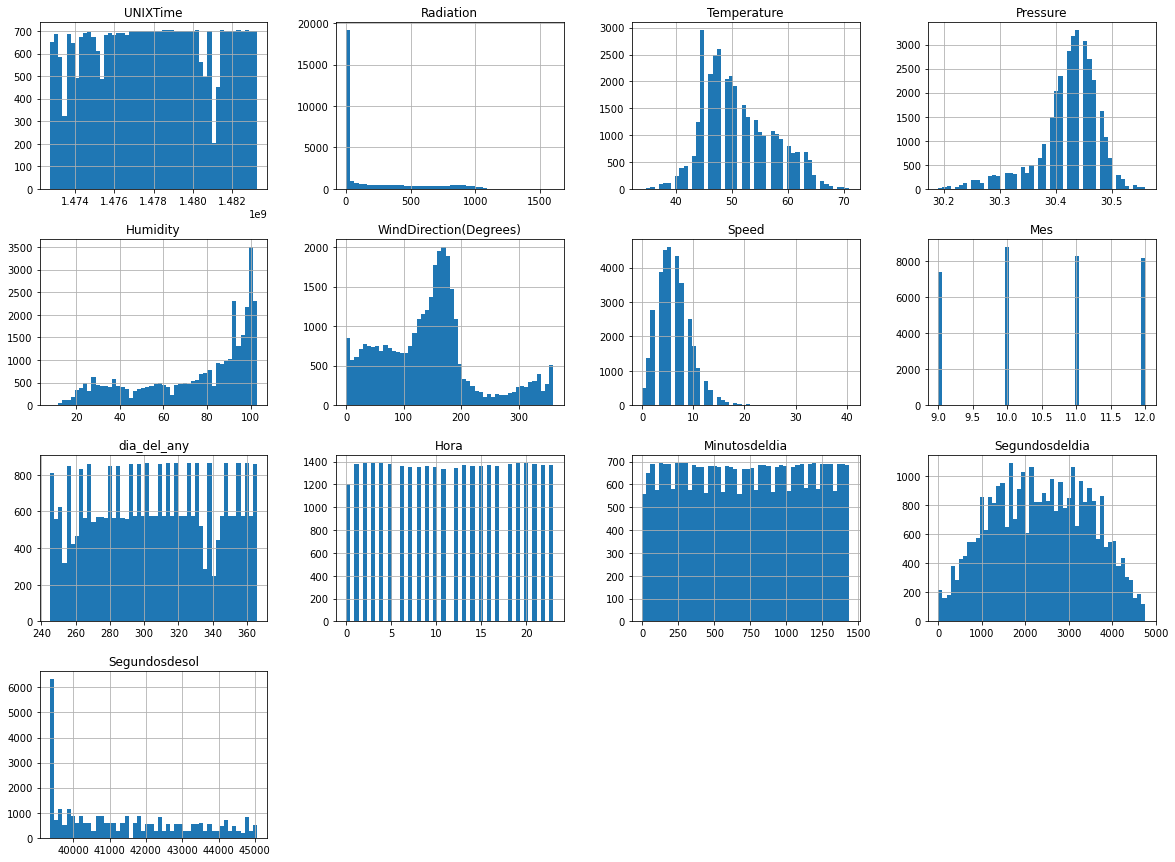

In [323]:
#Obseravmos las features gráficamente
dataset.hist(bins=50, figsize=(20,15))

A partir de los histogramas podemos obervar algunas anomalias:
- La radiación tiene una serie de datos muy por encima del resto de datos, son los datos de las horas de la noche donde no hay radiación
- La temperatura en Farenheid, tiene una distribución que se parece a una normal con desviación a la derecha, una asimemtria positiva, lo mismo ocurre con la velocidad del viento.
- La presión muestra una asimetria a la izquierda y por tanto negativa, lo mismo ocurre pero de forma más pronunciada en la humedad.

In [388]:
dataset.describe() #valores estadísticos

,UNIXTime,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,Mes,dia_del_any,Hora,Minutosdeldia,Segundosdeldia,Segundosdesol
count,3.268600e+04,32686.000000,32686.000000,32686.000000,32686.000000,32686.000000,32686.000000,32686.000000,32686.000000,32686.000000,32686.000000,32686.000000,32686.000000
mean,1.478047e+09,207.124697,51.103255,30.422879,75.016307,143.489821,6.243869,10.526066,306.110965,11.557425,721.002203,2364.288870,41433.032491
std,3.005037e+06,315.916387,6.201157,0.054673,25.990219,83.167500,3.490474,1.096691,34.781367,6.912034,415.011513,1114.592999,1795.873502
min,1.472724e+09,1.110000,34.000000,30.190000,8.000000,0.090000,0.000000,9.000000,245.000000,0.000000,0.000000,1.000000,39360.000000
25%,1.475546e+09,1.230000,46.000000,30.400000,56.000000,82.227500,3.370000,10.000000,277.000000,6.000000,360.000000,1461.000000,39720.000000
50%,1.478026e+09,2.660000,50.000000,30.430000,85.000000,147.700000,5.620000,11.000000,306.000000,12.000000,720.000000,2360.000000,41040.000000
75%,1.480480e+09,354.235000,55.000000,30.460000,97.000000,179.310000,7.870000,11.000000,334.000000,18.000000,1080.000000,3259.750000,42900.000000
max,1.483265e+09,1601.260000,71.000000,30.560000,103.000000,359.950000,40.500000,12.000000,366.000000,23.000000,1436.000000,4765.000000,45060.000000


In [325]:
#mediana
dataset.median(axis=0)

UNIXTime                  1.478026e+09
Radiation                 2.660000e+00
Temperature               5.000000e+01
Pressure                  3.043000e+01
Humidity                  8.500000e+01
WindDirection(Degrees)    1.477000e+02
Speed                     5.620000e+00
Mes                       1.100000e+01
dia_del_any               3.060000e+02
Hora                      1.200000e+01
Minutosdeldia             7.200000e+02
Segundosdeldia            2.360000e+03
Segundosdesol             4.104000e+04
dtype: float64

Tal como se obervaba en los histogramas, la media es superior a la mediana en temperatura y dirección de viento. También se observa la media superior a la mediana en la presión, a diferencia de lo que parecia en el histogrma. En cambio es inferior en Humedad.

La varianza es muy elevada en la Radiación, pero tiene la explicación de que se siguien tomando los datos durante la noche.

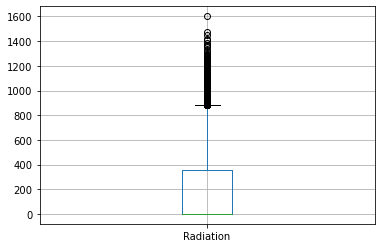

In [326]:
#Visualización de los histogramas con Pandas
boxplot_r = dataset.boxplot(column=["Radiation"])

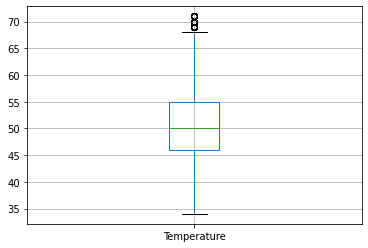

In [327]:
boxplot_t = dataset.boxplot(column=["Temperature"])

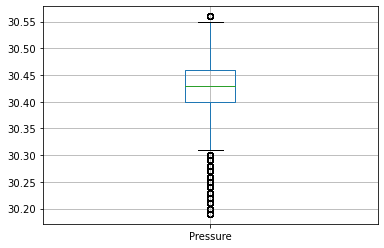

In [328]:
boxplot_p = dataset.boxplot(column=["Pressure"])

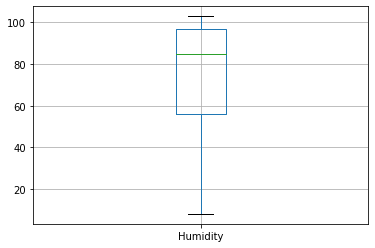

In [329]:
boxplot_p = dataset.boxplot(column=["Humidity"])

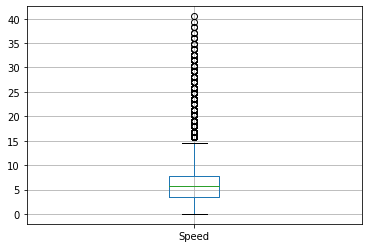

In [330]:
boxplot_p = dataset.boxplot(column=["Speed"])

Se considera que la velocidad del viento puede ser alta en días puntuales.

Estudiamos si los valores de radiación son descritocs como Outliers
Análisis de valores extremos (Extreme Value Analysis)

In [331]:
# Calculamos el rango intercuartílico
IQR = dataset["Radiation"].quantile(0.75) - dataset["Radiation"].quantile(0.25)

In [332]:
# Calculamos el límite superior (normal y extremo)
limSup = dataset["Radiation"].quantile(0.75) + (IQR *  1.5)
limSupExt = dataset["Radiation"].quantile(0.75) + (IQR *  3)

In [333]:
#Vamos a ver la proporción de observaciones que se encuentra por encima de estos límites:
total = dataset["Radiation"].shape[0]

In [334]:
# Examinamos el límite superior
len(dataset[dataset["Radiation"] > limSup])/total

0.06011748149054641

un 6% de las observaciones está por encima del límite superior extremo

In [505]:
# Calculámos el límite inferior (normal y extremo)
limInf = dataset["Radiation"].quantile(0.25) - (IQR *  1.5)
limInfExt = dataset["Radiation"].quantile(0.25) - (IQR *  3)

In [336]:
# Examinamos el límite inferior
len(dataset[dataset["Radiation"] < limInf])/total

0.0

El 0% nos indica que no son valores anomalos extremos, sino que hay muchos horas sin radiación

In [337]:
#Calculo de Z-Score
z = stats.zscore(dataset["Radiation"])
print("max: ",z.max(), "Min :", z.min())
z

max:  4.413055750692607 Min : -0.6521277694597974


array([-0.65181123, -0.65181123, -0.65174792, ..., -0.65184288,
       -0.65174792, -0.65184288])

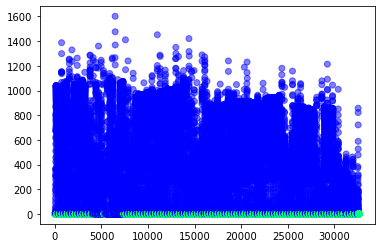

In [338]:
# Un gráfico de dispersión a veces nos da perspectiva de nuestros posibles outliers
plt.scatter(np.arange(len(dataset)), dataset["Radiation"], c=z<-0.65, cmap=plt.get_cmap("winter"), alpha=0.5)

No se consideramos los valores como Outliers, por lo tanto siguimos estudiando el dataset

In [431]:
#nos quedamos con las variables utiles
dataset2=dataset[["Radiation","Temperature","Pressure","Humidity","WindDirection(Degrees)","Speed","Segundosdesol", "dia_del_any","Segundosdeldia"]]
dataset2

,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,Segundosdesol,dia_del_any,Segundosdeldia
UNIXTime,,,,,,,,,
2016-09-29 23:55:26-10:00,1.21,48,30.46,59,177.39,5.62,43200.0,273,4706
2016-09-29 23:50:23-10:00,1.21,48,30.46,58,176.78,3.37,43200.0,273,4403
2016-09-29 23:45:26-10:00,1.23,48,30.46,57,158.75,3.37,43200.0,273,4106
2016-09-29 23:40:21-10:00,1.21,48,30.46,60,137.71,3.37,43200.0,273,3801
2016-09-29 23:35:24-10:00,1.17,48,30.46,62,104.95,5.62,43200.0,273,3504
...,...,...,...,...,...,...,...,...,...
2016-12-01 00:20:04-10:00,1.22,44,30.43,102,145.42,6.75,39660.0,336,1204
2016-12-01 00:15:01-10:00,1.17,44,30.42,102,117.78,6.75,39660.0,336,901
2016-12-01 00:10:01-10:00,1.20,44,30.42,102,145.19,9.00,39660.0,336,601


## Correlaciones entre variables

In [432]:
dataset2.corr()

,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,Segundosdesol,dia_del_any,Segundosdeldia
Radiation,1.000000,0.734955,0.119016,-0.226171,-0.230324,0.073627,0.073456,-0.081320,0.000595
Temperature,0.734955,1.000000,0.311173,-0.285055,-0.259421,-0.031458,0.355509,-0.370794,0.071256
Pressure,0.119016,0.311173,1.000000,-0.223973,-0.229010,-0.083639,0.278614,-0.332762,0.035253
Humidity,-0.226171,-0.285055,-0.223973,1.000000,-0.001833,-0.211624,0.087356,-0.063760,0.029127
WindDirection(Degrees),-0.230324,-0.259421,-0.229010,-0.001833,1.000000,0.073092,-0.129434,0.153255,-0.029949
Speed,0.073627,-0.031458,-0.083639,-0.211624,0.073092,1.000000,-0.174944,0.174336,-0.021763
Segundosdesol,0.073456,0.355509,0.278614,0.087356,-0.129434,-0.174944,1.000000,-0.978641,0.000931
dia_del_any,-0.081320,-0.370794,-0.332762,-0.063760,0.153255,0.174336,-0.978641,1.000000,0.000084
Segundosdeldia,0.000595,0.071256,0.035253,0.029127,-0.029949,-0.021763,0.000931,0.000084,1.000000


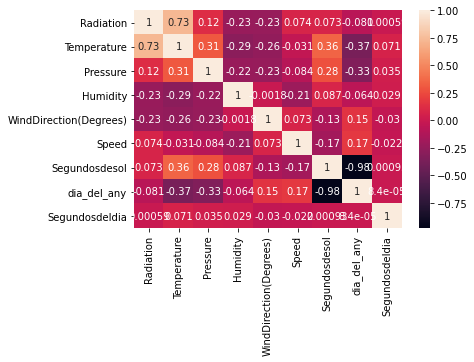

In [434]:
sn.heatmap(dataset2.corr(), annot=True)
plt.show()

Observamos alta correlación entre Radiación y tempreatura. Una correlación más floja con la Presión y Segundos de Sol.

También se observa una correlacion negativa, aunque muy baja, con la humedad y direccíon del viento. La correlación entre día del año y segundos de sol tiene una fuerta correlación negativa, pero no le damos importancia ya que uan depende la otra.

Por un momento se podria pensar que la dirección del viento y la humedad estaria correlacionadas, por ejemplo si estubiera cerca el mar, pero la matriz de correlaciones nos indica que no hay correlación entre las dos variables.

In [435]:
dataset2

,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,Segundosdesol,dia_del_any,Segundosdeldia
UNIXTime,,,,,,,,,
2016-09-29 23:55:26-10:00,1.21,48,30.46,59,177.39,5.62,43200.0,273,4706
2016-09-29 23:50:23-10:00,1.21,48,30.46,58,176.78,3.37,43200.0,273,4403
2016-09-29 23:45:26-10:00,1.23,48,30.46,57,158.75,3.37,43200.0,273,4106
2016-09-29 23:40:21-10:00,1.21,48,30.46,60,137.71,3.37,43200.0,273,3801
2016-09-29 23:35:24-10:00,1.17,48,30.46,62,104.95,5.62,43200.0,273,3504
...,...,...,...,...,...,...,...,...,...
2016-12-01 00:20:04-10:00,1.22,44,30.43,102,145.42,6.75,39660.0,336,1204
2016-12-01 00:15:01-10:00,1.17,44,30.42,102,117.78,6.75,39660.0,336,901
2016-12-01 00:10:01-10:00,1.20,44,30.42,102,145.19,9.00,39660.0,336,601


Determinar que featrues son más importantes en el Dataset

#### DecisionTreeRegressor

In [ ]:
# Dividimos el dataset features y target

In [436]:
X= dataset2[["Temperature","Pressure","Humidity","WindDirection(Degrees)","Speed","Segundosdesol",  "dia_del_any","Segundosdeldia"]]
y= dataset2["Radiation"]

In [437]:
from sklearn.tree import DecisionTreeRegressor


In [438]:
arbolr=DecisionTreeRegressor()

In [439]:
arbolr.fit(X, y)

DecisionTreeRegressor()

In [440]:
arbolr.feature_importances_

array([0.61667685, 0.05525985, 0.08172517, 0.04389493, 0.02158402,
       0.04433892, 0.11218866, 0.02433161])

In [442]:
columnas=["Temperature","Pressure","Humidity","WindDirection(Degrees)","Speed","Segundosdesol", "dia_del_any","Segundosdeldia"]

In [443]:
serie_importancia=pd.Series(arbolr.feature_importances_, index=columnas)
serie_importancia

Temperature               0.616677
Pressure                  0.055260
Humidity                  0.081725
WindDirection(Degrees)    0.043895
Speed                     0.021584
Segundosdesol             0.044339
dia_del_any               0.112189
Segundosdeldia            0.024332
dtype: float64

In [444]:
serie_importancia.sort_values(ascending=False)

Temperature               0.616677
dia_del_any               0.112189
Humidity                  0.081725
Pressure                  0.055260
Segundosdesol             0.044339
WindDirection(Degrees)    0.043895
Segundosdeldia            0.024332
Speed                     0.021584
dtype: float64

In [445]:
df_importancia=pd.DataFrame(serie_importancia, columns=["Importancia sin acumular"])

In [446]:
df_importancia.sort_values(by=["Importancia sin acumular"], ascending=False, inplace=True)

In [447]:
df_importancia

,Importancia sin acumular
Temperature,0.616677
dia_del_any,0.112189
Humidity,0.081725
Pressure,0.055260
Segundosdesol,0.044339
WindDirection(Degrees),0.043895
Segundosdeldia,0.024332
Speed,0.021584


In [448]:
np.cumsum(df_importancia["Importancia sin acumular"])

Temperature               0.616677
dia_del_any               0.728866
Humidity                  0.810591
Pressure                  0.865851
Segundosdesol             0.910189
WindDirection(Degrees)    0.954084
Segundosdeldia            0.978416
Speed                     1.000000
Name: Importancia sin acumular, dtype: float64

In [449]:
df_importancia["Importancia acumulada"]=np.cumsum(df_importancia["Importancia sin acumular"])

In [450]:
df_importancia

,Importancia sin acumular,Importancia acumulada
Temperature,0.616677,0.616677
dia_del_any,0.112189,0.728866
Humidity,0.081725,0.810591
Pressure,0.055260,0.865851
Segundosdesol,0.044339,0.910189
WindDirection(Degrees),0.043895,0.954084
Segundosdeldia,0.024332,0.978416
Speed,0.021584,1.000000


In [451]:
#nos quedamos con el 95% de importancia
df_importancia[df_importancia["Importancia acumulada"]<0.95]

,Importancia sin acumular,Importancia acumulada
Temperature,0.616677,0.616677
dia_del_any,0.112189,0.728866
Humidity,0.081725,0.810591
Pressure,0.055260,0.865851
Segundosdesol,0.044339,0.910189


In [452]:
dataset3=dataset2[["Radiation","Temperature","Segundosdesol","Humidity","Pressure", "dia_del_any"]]
dataset3

,Radiation,Temperature,Segundosdesol,Humidity,Pressure,dia_del_any
UNIXTime,,,,,,
2016-09-29 23:55:26-10:00,1.21,48,43200.0,59,30.46,273
2016-09-29 23:50:23-10:00,1.21,48,43200.0,58,30.46,273
2016-09-29 23:45:26-10:00,1.23,48,43200.0,57,30.46,273
2016-09-29 23:40:21-10:00,1.21,48,43200.0,60,30.46,273
2016-09-29 23:35:24-10:00,1.17,48,43200.0,62,30.46,273
...,...,...,...,...,...,...
2016-12-01 00:20:04-10:00,1.22,44,39660.0,102,30.43,336
2016-12-01 00:15:01-10:00,1.17,44,39660.0,102,30.42,336
2016-12-01 00:10:01-10:00,1.20,44,39660.0,102,30.42,336


In [453]:
X= dataset3[["Temperature","Segundosdesol","Humidity","Pressure", "dia_del_any"]]
y= dataset3["Radiation"]

In [454]:
#dividomos en train (80%) y test (20%)

In [455]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [456]:
#Regresion lineal para el conjunto de test

In [457]:
from sklearn.linear_model import LinearRegression

In [458]:
lr=LinearRegression()

In [459]:
lr.fit(X=X_train, y=y_train)

LinearRegression()

In [460]:
lr.predict(X_test)

array([573.51437206, 105.34597551, 595.94797403, ...,   5.85048272,
       271.15207085, 404.14574766])

In [461]:
y_test.values

array([477.77, 399.87, 910.28, ...,   1.25, 161.85,   1.27])

In [462]:
lr.score(X_test, y_test)

0.5897646610163512

In [463]:
#el reulutado obtenido un pobre 58% de precisión. Debemos estudiar otros tipos de Regressiones.

### Random Forest Regressor

In [464]:
from sklearn.ensemble import RandomForestRegressor

In [489]:
randomf = RandomForestRegressor(n_estimators = 200)

In [490]:
randomf.fit(X=X_train, y=y_train)

RandomForestRegressor(n_estimators=200)

In [491]:
randomf.predict(X_test)

array([501.42437619,  45.29810333, 694.44904702, ...,   1.2676    ,
       189.7824175 , 149.26273333])

In [492]:
randomf.score(X_test, y_test)

0.8971461183412376

In [493]:
#subimos a un 89% de precisión

#calculo del RMSE

In [494]:
from sklearn.metrics import mean_squared_error

In [506]:
# Medimos el MSE en el conjunto de testing.
mse = mean_squared_error(y_test,
                         y_pred=randomf.predict(X_test))

# El RMSE es la raíz de este valor
rmse = np.sqrt(mse)

print("MSE: " + str(mse))
print("RMSE: " +  str(rmse))

MSE: 10414.091747630076
RMSE: 102.04945736078206


In [496]:
#en termino medio la predicción falla en 102 w/m2

In [497]:
y_pred=randomf.predict(X_test)

In [498]:
# Predicting for whole dataset
dataset['y_pred'] = randomf.predict(dataset[["Temperature","Segundosdesol","Humidity","Pressure", "dia_del_any"]])

In [499]:
# Create Interactive Plot Using Bokeh
from bokeh.plotting import figure, output_notebook, show
from bokeh.models import Range1d
output_notebook() 

Loading BokehJS ...

In [500]:
p = figure(plot_width=800, 
           plot_height=400,
           title="Predición de la Radiación Solar con Random Forest",
           x_axis_label='Hora',
           y_axis_label='Radiación Solar',
           x_axis_type="datetime")
p.x_range = Range1d(dataset.index[2300], dataset.index[2470])
p.y_range = Range1d(-100, 1800, bounds=(-100, 1800))
p.line(dataset.index, dataset['Radiation'], legend='Radiación Solar Observada', line_width=1,line_color="orange")
p.line(dataset.index, dataset['y_pred'], legend='Radiación Solar Predicha', line_width=1, line_color="red")

show(p, notebook_handle = True)

## Conclusiones

El modelo que se ha obtenido con los datos, demuestran una capacidad de predicción del 89,7%. Las variables que más han aportado al modelo son la Temperatura, Horas de sol durante el dia, Humedad, presión y día de año.

Con éste resultado se puede predecir el comportamiento que debería tener una placa solar o una bateria. Y seriviría para detectar mal funcionamiento de las instalaciones a tiempo real.

Con datos de previsiones del precio eléctrico se podría predecir el resultado económico previsto para dicha instalación.

El error del modelo es de 102 w/m².

Los datos son de Opendatabasa obtenidos en https://www.kaggle.com/dronio/SolarEnergy, algunas variables y representación tienen como fuente de inspiración a callumdownie.